In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
 
import datetime
import gzip

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
url_review = '/content/drive/My Drive/Data/steam_reviews.json.gz'

In [4]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse(url_review):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

# Parte A Exploración de datos

## Reviews

In [5]:
data_reviews = pd.DataFrame(data_reviews)

In [7]:
data_reviews.head(4)

,username,hours,products,product_id,date,text,user_id,found_funny
0,Chaos Syren,0.1,41.0,725280,2017-12-17,This would not be acceptable as an entertainme...,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2017-08-02,Addictive RPG ! Works fine on linux though it ...,NaN,NaN
2,freakfantom,0.1,1706.0,725280,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,76561198003030375,NaN


In [8]:
data_reviews.shape

(779307, 8)

In [9]:
data_reviews.dtypes

username        object
hours          float64
products       float64
product_id      object
date            object
text            object
user_id         object
found_funny    float64
dtype: object

In [6]:
#Elimino columnas
data_reviews.drop(['page_order', 'page', 'early_access', 'compensation'], axis=1, inplace=True)

In [10]:
#Porcentaje de valores nulos
print('Porcentaje de valores nulos')
data_reviews.isnull().sum() / data_reviews.shape[0] * 100

Porcentaje de valores nulos


username        0.000000
hours           0.338378
products        0.200948
product_id      0.000000
date            0.000000
text            0.000000
user_id        59.279206
found_funny    84.580659
dtype: float64

In [11]:
print('Un total de {} usuarios realizaron reviews de videojuegos'.format(len(data_reviews.username.unique())))

Un total de 540341 usuarios realizaron reviews de videojuegos


In [128]:
print("<-- Top 10 de Usuarios con mas reviews -->")
data_reviews.username.value_counts().head(10)

<-- Top 10 de Usuarios con mas reviews -->


123            213
Alex           190
Chris          155
Nick           143
Matt           137
Tom            129
John           128
Jack           123
Dan            119
Saint Aaron    114
Name: username, dtype: int64

In [131]:
print('<-- Top 10 sVideojuegos con mas reviews --> ')
top_games = data_reviews.product_id.value_counts().head(10)
i = 0
while i <= 9:
  ids = top_games.index[i]
  ids = data_games[data_games['id'] == ids]
  print('-->', ids.title.iloc[0])
  i = i + 1

<-- Top 10 id_Videojuegos con mas reviews --> 
--> Team Fortress 2
--> Rust
--> Borderlands 2
--> Fallout 4
--> Grand Theft Auto V
--> Undertale
--> Portal 2
--> Warframe
--> DayZ
--> Robocraft


In [132]:
#Conversion a tipo datetime64
data_reviews['Fecha'] = pd.to_datetime(data_reviews['date'])
data_reviews['Year'] = data_reviews['Fecha'].dt.year            #Nueva columna con el año del review
data_reviews['month'] = data_reviews['Fecha'].dt.month          #Nueva columna con el mes del review

In [133]:
year_review = data_reviews.groupby(['Year']).count()
year_review

,username,hours,products,product_id,date,text,user_id,found_funny,Fecha,month
Year,,,,,,,,,,
2010,1283,1250,1281,1283,1283,1283,201,46,1283,1283
2011,7421,7229,7417,7421,7421,7421,1527,226,7421,7421
2012,10349,10137,10346,10349,10349,10349,2478,340,10349,10349
2013,32888,32625,32833,32888,32888,32888,10307,1323,32888,32888
2014,118323,118320,117778,118323,118323,118323,46645,8424,118323,118323
2015,157862,156787,157682,157862,157862,157862,63348,29822,157862,157862
2016,203854,203309,203548,203854,203854,203854,84455,39105,203854,203854
2017,242121,241816,241663,242121,242121,242121,105972,40390,242121,242121
2018,5206,5197,5193,5206,5206,5206,2407,488,5206,5206


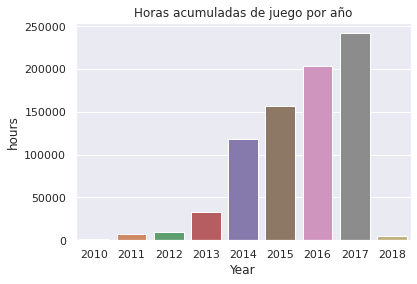

In [134]:
plt.title('Horas acumuladas de juego por año')
sns.barplot(x = year_review.index,
            y=year_review.hours)

In [141]:
months_2017 = data_reviews[data_reviews['Year'] == 2017].groupby(['month']).count()

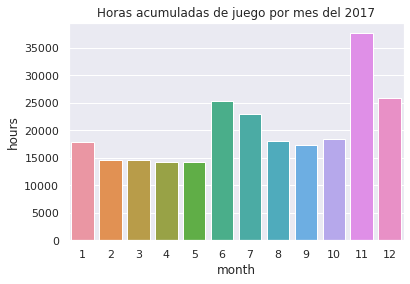

In [142]:
plt.title('Horas acumuladas de juego por mes del 2017')
sns.barplot(x= months_2017.index,
            y=months_2017.hours)

 ## Info Games

In [173]:
url_games = '/content/drive/My Drive/Data/steam_games.json.gz'

In [174]:
data_games = []
for l in parse(url_games):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [175]:
data_games.shape

(32135, 16)

In [176]:
data_games.dtypes

publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
id                 object
developer          object
sentiment          object
metascore          object
dtype: object

In [177]:
data_games.drop(['reviews_url', 'url', 'early_access', 'discount_price'], axis=1, inplace=True)

In [178]:
data_games.head(2)

,publisher,genres,app_name,title,release_date,tags,specs,price,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",Free To Play,643980,Secret Level SRL,Mostly Positive,NaN


In [179]:
data_games.shape

(32135, 12)

In [180]:
 print('Porcentaje de valor nulos')
data_games.isnull().sum() / data_games.shape[0] *100

Porcentaje de valor nulos


publisher       25.056792
genres          10.216275
app_name         0.006224
title            6.379337
release_date     6.432239
tags             0.507235
specs            2.084954
price            4.285047
id               0.006224
developer       10.266065
sentiment       22.349463
metascore       91.669519
dtype: float64

In [168]:
print('<-- Desarrolladores con mas videojuegos registrados -->\n')
data_games.developer.value_counts().head(10)

<-- Desarrolladores con mas videojuegos registrados -->



Ubisoft - San Francisco       1259
SmiteWorks USA, LLC            813
Dovetail Games                 253
KOEI TECMO GAMES CO., LTD.     232
Paradox Development Studio     156
Capcom                         130
Ronimo Games                   123
Choice of Games                100
Stainless Games                 95
Musopia                         95
Name: developer, dtype: int64

Text(0, 0.5, 'Frecuencia')

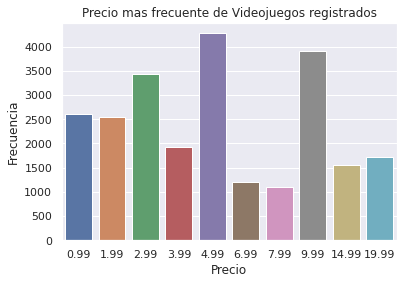

In [212]:
price_games = data_games.price.value_counts().head(10)
sns.barplot(x=price_games.index[0:],
            y=price_games)
plt.title('Precio mas frecuente de Videojuegos registrados')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')